<a href="https://colab.research.google.com/github/rsadaphule/jhu-cv/blob/main/v3_JHU_CV_HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Write a python code for a conditional GAN (cGAN) architecture using the code in reference [1] and MNIST dataset to perform the following mappings (i.e., odd digit to even digit image image):


**Step 1: Import Libraries**

In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



Step 2: Define the Generator and Discriminator
In a cGAN, both the generator and discriminator receive the condition. Here, the condition is the image of an even digit.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Input: Concatenated image (even digit) and noise vector
        self.model = nn.Sequential(
            nn.Linear(110, 256),  # 28*28 + 10 (one-hot vector for condition)
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()  # Output images are normalized between -1 and 1
        )

    def forward(self, noise, labels):
        # Concatenate noise and labels, process them, and return generated images
        # This is a simplified representation
        x = torch.cat((noise, labels), -1)
        return self.model(x)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Assuming img_shape is the flattened image vector size
        # and label_shape is the size of the one-hot encoded labels
        img_shape = 784  # 28x28 pixels flattened
        label_shape = 10  # One-hot encoded labels for digits 0-9
        self.model = nn.Sequential(
            nn.Linear(img_shape + label_shape, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Flatten image if it's not already
        img_flat = img.view(img.size(0), -1)
        # Concatenate label (condition) and image
        x = torch.cat((img_flat, labels), -1)
        return self.model(x)


#Step 3: Prepare the Dataset
For simplicity, this code assumes you have a way to pair even MNIST digits with their odd counterparts. This step might involve creating a custom dataset class that filters even digits and pairs them with artificially generated odd digits or labels.

In [9]:
from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torch.utils.data import Dataset

class EvenToOddMNIST(Dataset):
    def __init__(self, root='./data', train=True, transform=None, target_transform=None):
        self.mnist = MNIST(root=root, train=train, download=True, transform=transform)
        self.even_indices = [i for i, (_, label) in enumerate(self.mnist) if label % 2 == 0]
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, label = self.mnist[self.even_indices[index]]
        # Increment label to get the next odd digit
        odd_label = label + 1
        # Convert label to one-hot encoding
        label_one_hot = torch.zeros(10)
        label_one_hot[odd_label] = 1.0
        return img, label_one_hot

    def __len__(self):
        return len(self.even_indices)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Example usage
train_dataset = EvenToOddMNIST(root='./data', train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 461936949.26it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26259634.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 223165259.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4583861.59it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#Step 4: Initialize Models, Optimizers, and Loss Function

In [10]:
# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Step 5: Training Loop
The training loop involves feeding both the noise (plus condition) to the generator and the real images (plus condition) to the discriminator. For simplicity, this example won't include the complete loop but focus on the key parts involving conditions.

[Epoch 1/50] [D loss: 0.47562414768390326] [G loss: 2.7969553753765957]
[Epoch 2/50] [D loss: 0.3518317455787983] [G loss: 2.443474840445529]
[Epoch 3/50] [D loss: 0.23439807291829517] [G loss: 3.4203763556325253]
[Epoch 4/50] [D loss: 0.13500812819722277] [G loss: 4.164071493965944]
[Epoch 5/50] [D loss: 0.14094059350051857] [G loss: 4.444653581124841]
[Epoch 6/50] [D loss: 0.13845702611241256] [G loss: 4.229760355132262]
[Epoch 7/50] [D loss: 0.19585959772112702] [G loss: 3.4175992398613704]
[Epoch 8/50] [D loss: 0.1971681699290096] [G loss: 3.287824034690857]
[Epoch 9/50] [D loss: 0.2645063911304039] [G loss: 2.7833378649844005]
[Epoch 10/50] [D loss: 0.24999335166592143] [G loss: 2.9348132715049378]
[Epoch 11/50] [D loss: 0.22345686173813978] [G loss: 3.123980373855268]
[Epoch 12/50] [D loss: 0.2661755957323533] [G loss: 2.759075340764383]
[Epoch 13/50] [D loss: 0.2644273845757683] [G loss: 2.842793577405222]
[Epoch 14/50] [D loss: 0.3062686869741262] [G loss: 2.421137853454871]
[E

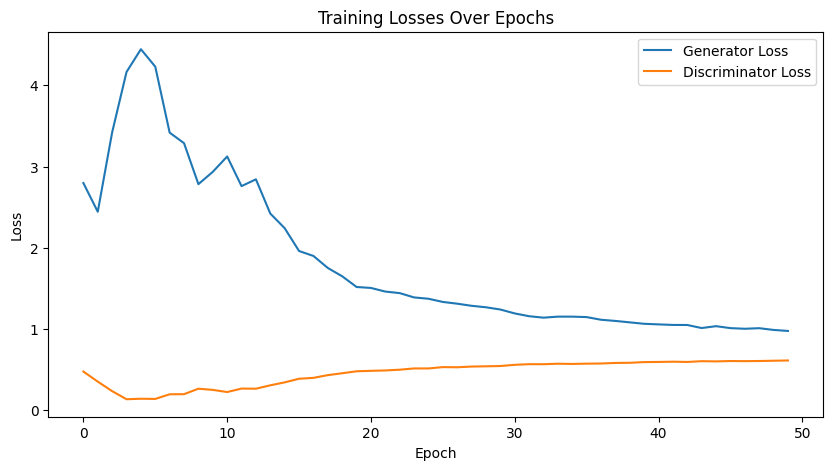

In [11]:
num_epochs = 50  # Adjust as per requirement
g_loss_history = []  # To store generator loss
d_loss_history = []  # To store discriminator loss

for epoch in range(num_epochs):
    g_loss_accum = 0.0
    d_loss_accum = 0.0
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.shape[0]

        # Labels for real and fake images
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        # Configure input
        real_imgs = imgs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)

        # Zero the parameter gradients
        d_optimizer.zero_grad()

        # Train Discriminator with real images
        real_pred = discriminator(real_imgs, labels)
        d_real_loss = criterion(real_pred, valid)

        # Train Discriminator with fake images
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 100))).to(device)
        gen_imgs = generator(noise, labels)
        fake_pred = discriminator(gen_imgs.detach(), labels)
        d_fake_loss = criterion(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()

        # Generator's goal is to fool the discriminator
        fake_pred = discriminator(gen_imgs, labels)
        g_loss = criterion(fake_pred, valid)

        g_loss.backward()
        g_optimizer.step()

        g_loss_accum += g_loss.item()
        d_loss_accum += d_loss.item()

    g_loss_history.append(g_loss_accum / len(train_loader))
    d_loss_history.append(d_loss_accum / len(train_loader))
    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {d_loss_accum / len(train_loader)}] [G loss: {g_loss_accum / len(train_loader)}]")



plt.figure(figsize=(10, 5))
plt.plot(g_loss_history, label='Generator Loss')
plt.plot(d_loss_history, label='Discriminator Loss')
plt.title("Training Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Verify

In [51]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformation for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [52]:
for img, label in test_loader:
    if label % 2 == 1:  # Check if the label is an even number
        odd_img = img
        odd_label = label
        break


print(odd_label[0].numpy())



3


In [53]:
import torch

# Specify the desired output digit
desired_output_digit = odd_label  # For example, we want to generate a "9"

# Create a one-hot encoded vector for the desired digit
one_hot_label = torch.zeros(10)  # Initialize a zero vector of length 10
one_hot_label[desired_output_digit] = 1  # Set the index of the desired digit to 1

# Ensure the one-hot label is the right shape for the generator's expected input
# This often means unsqueezing to add batch dimensions if necessary
one_hot_label = one_hot_label.unsqueeze(0)  # Add a batch dimension

# If using a GPU, move the noise and label to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
one_hot_label = one_hot_label.to(device)
noise = torch.randn(1, 100).to(device)  # Assuming the generator expects a 100-dimensional noise vector

# Generate the image with the generator
generator.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    generated_img = generator(noise, one_hot_label).cpu()  # Generate the image


Original odd digit label: 3
2


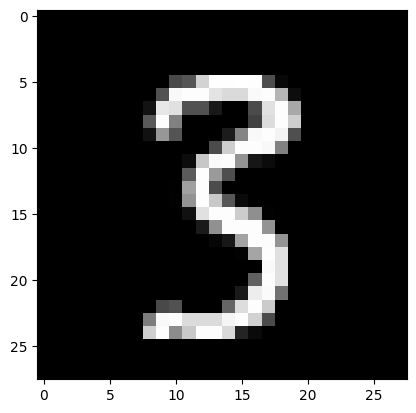

Generated digit:
2


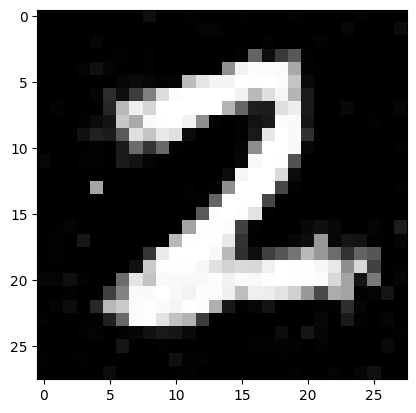

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    # Check if the image is flattened and reshape it to 2D if necessary
    print(img.dim())
    if img.dim() == 2:  # If the tensor is 1D (flattened image), reshape it
        img = img.view(28, 28)  # Reshape to 28x28 for MNIST images
    elif img.dim() == 3 and img.shape[0] == 1:  # If there's an extra channel dimension
        img = img.squeeze(0)  # Remove the channel dimension for grayscale images

    img = img.cpu()  # Ensure the tensor is moved to CPU
    npimg = img.numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()


# Now when you call imshow, it should work regardless of whether the tensor is on the CPU or GPU
print(f"Original odd digit label: {odd_label.item()}")
imshow(odd_img.squeeze())

# Assuming `generated_img` is the output from your generator
print("Generated digit:")
imshow(generated_img)
